### Shows how to generate an image from a reference image with SDXL 1.0 (on demand).
> Sources: 
> https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-diffusion-1-0-image-image.html
> https://github.com/aws-samples/amazon-bedrock-workshop/blob/main/04_Image_and_Multimodal/bedrock-stable-diffusionXL.ipynb

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
"""
"""
import base64
import io
import os
import json
import logging
import boto3
from PIL import Image
from botocore.exceptions import ClientError

In [11]:
# SDK init
bedrock_client = boto3.client(service_name='bedrock-runtime')

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [18]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

In [19]:
user_prompt = "add the ocean at the horizon"
negative_prompts = [
    "poorly rendered",
    "poor water details",
    "disfigured features",
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "FAST_GREEN" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "K_DPMPP_2S_ANCESTRAL" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)
width = 768

In [27]:
# Set image:
input_image = "assets/ricardo-resende-304I-LOQfjw-unsplash.jpg"
init_image_b64 = image_to_base64(input_image)

Reading image from file: assets/ricardo-resende-304I-LOQfjw-unsplash.jpg


In [28]:
request = json.dumps({
    "text_prompts": (
        [{"text": user_prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "init_image": init_image_b64,
    "seed": 321,
    "start_schedule": 0.6,
    "steps": 50,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
})
modelId = "stability.stable-diffusion-xl-v1"

response = bedrock_client.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAALACAIAAABq8l0ZAADgAmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


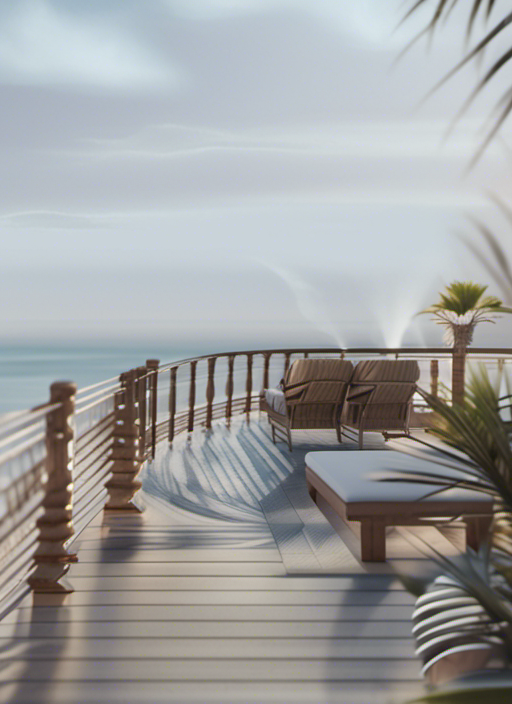

In [29]:
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
image_1